# Image Classification
In this project, I'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. I'll preprocess the images, then train a convolutional neural network on all the samples. The images will be normalized and the labels one-hot encoded.  I'll apply a convolutional net, max pooling, dropout, and fully connected layers.  At the end, I'll test the neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!



Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 27:
Image - Min Value: 18 Max Value: 236
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


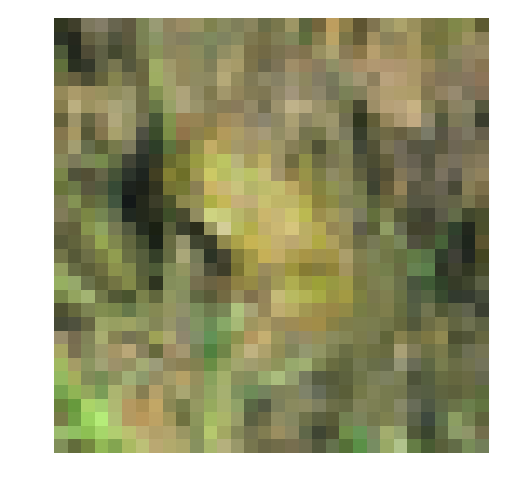

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 27
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below the `normalize` function will take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
from sklearn import preprocessing
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    min-max function: X' = a + ( ((x- Xmin)/(b-a))  /  (Xmax - Xmin) )
    """
    b = 1.0
    a = 0.0
    xMax = np.max(x)
    xMin = np.min(x)
    return (a + (((x - xMin)/(b-a)) / (xMax - xMin)) )

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, this is a function for preprocessing.  The `one_hot_encode` function will take input, `x`, are a list of labels.  The function will return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Will also save the map of encodings outside the function.

In [4]:
from sklearn import preprocessing
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    return np.eye(10)[x]
    """
    labels = np.array(x)
    lb = preprocessing.LabelBinarizer()
    lb.fit([0,1,2,3,4,5,6,7,8,9])
    return lb.transform(labels)

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again. (To do)

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is the first checkpoint. 

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** Quick access to Tensor API - [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers.

>Tensorflow `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d).

>Tensorflow Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 


### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # Completed: Implement Function
    height, width, depth = image_shape
    return tf.placeholder(tf.float32, shape=[None, height, width, depth], name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # Completed: Implement Function
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # Completed: Implement Function
    return tf.placeholder(tf.float32, name='keep_prob')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, I implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * Use 'SAME' padding
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * Use 'SAME' padding

In [1]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    #1 Create the variables for the weights and the bias
    input_depth = x_tensor.shape[3].value
    #input_depth = x_tensor.get_shape().as_list()[3]
    weights = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], input_depth, 
                                               conv_num_outputs], mean=0, stddev=0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    #2 Convolution
    conv_layer = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    
    #3 Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    #4 Activation layer
    conv_layer = tf.nn.relu(conv_layer)
    
    #5 Max Pooling
    conv_layer = tf.nn.max_pool(conv_layer, ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                           strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')
    return conv_layer

"""  
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

NameError: name 'tests' is not defined

### Flatten Layer
The `flatten` function changes the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). 

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    f_height, f_width, f_depth = x_tensor.get_shape().as_list()[1:]
    flat_size = f_height * f_width * f_depth
    return tf.reshape(x_tensor, [-1, flat_size])
    
    #return tf.contrib.layers.flatten(x_tensor)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement a `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    #1 Weights and bias
    batch_size = x_tensor.shape[1].value
    #batch_size = x_tensor.get_shape().as_list()[-1]
    weights = tf.Variable(tf.truncated_normal([batch_size, num_outputs]), name="weights_fully_connected")
    bias = tf.Variable(tf.zeros(num_outputs), name="bias_fully_connected")
    
    #2 Fully connected layer
    fc_layer = tf.nn.bias_add(tf.matmul(x_tensor, weights), bias)
    
    #3 Activation
    return tf.nn.relu(fc_layer)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    #1 Weights and bias
    batch_size = x_tensor.shape[1].value
    #batch_size = x_tensor.get_shape().as_list()[-1]  
    weights = tf.Variable(tf.truncated_normal([batch_size, num_outputs], mean=0, stddev=0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    #2 Fully connected layer
    layer_fully_connected = tf.nn.bias_add(tf.matmul(x_tensor, weights), bias)
    return layer_fully_connected
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### The Convolutional Model
Implement function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    # conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, 
    #                          conv_strides, pool_ksize, pool_strides)
    outputs = [16, 32, 64]
    conv_ksize = [4, 4]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    cnvNet_1 = conv2d_maxpool(x, outputs[0], conv_ksize, conv_strides, pool_ksize, pool_strides)
    cnvNet_2 = conv2d_maxpool(cnvNet_1, outputs[1], conv_ksize, conv_strides, pool_ksize, pool_strides)
    cnvNet_3 = conv2d_maxpool(cnvNet_2, outputs[2], conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # Apply a Flatten Layer
    cnvNet_3 = flatten(cnvNet_3)
    
    # Apply 1, 2, or 3 Fully Connected Layers
    # Play around with different number of outputs
    fconn_1 = fully_conn(cnvNet_3, 100)
    fconn_1 = tf.nn.dropout(fconn_1, keep_prob)
       
    # Set this to the number of classes
    # Function Definition from Above:
    cnvNet_output = output(fconn_1, 10)
    
    # TODO: return output
    return cnvNet_output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # Completed: Implement Function
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, 
                             keep_prob: keep_probability})

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # Completed: Implement Function
    cost = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    print('Loss: ', cost, ' Accuracy: ', accuracy)    

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [15]:
# TODO: Tune Parameters
epochs = 20
batch_size = 256
keep_probability = .75

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:  2.17001  Accuracy:  0.1868
Epoch  2, CIFAR-10 Batch 1:  Loss:  2.00422  Accuracy:  0.2972
Epoch  3, CIFAR-10 Batch 1:  Loss:  1.82212  Accuracy:  0.3686
Epoch  4, CIFAR-10 Batch 1:  Loss:  1.68886  Accuracy:  0.3918
Epoch  5, CIFAR-10 Batch 1:  Loss:  1.55248  Accuracy:  0.4208
Epoch  6, CIFAR-10 Batch 1:  Loss:  1.42559  Accuracy:  0.4312
Epoch  7, CIFAR-10 Batch 1:  Loss:  1.25867  Accuracy:  0.4496
Epoch  8, CIFAR-10 Batch 1:  Loss:  1.16904  Accuracy:  0.4488
Epoch  9, CIFAR-10 Batch 1:  Loss:  1.12938  Accuracy:  0.443
Epoch 10, CIFAR-10 Batch 1:  Loss:  1.03633  Accuracy:  0.4454
Epoch 11, CIFAR-10 Batch 1:  Loss:  0.979828  Accuracy:  0.4608
Epoch 12, CIFAR-10 Batch 1:  Loss:  0.838433  Accuracy:  0.468
Epoch 13, CIFAR-10 Batch 1:  Loss:  0.7978  Accuracy:  0.4702
Epoch 14, CIFAR-10 Batch 1:  Loss:  0.758777  Accuracy:  0.4692
Epoch 15, CIFAR-10 Batch 1:  Loss:  0.653916  Accuracy:  0.4938
Epoch 16, C

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:  2.14333  Accuracy:  0.1964
Epoch  1, CIFAR-10 Batch 2:  Loss:  2.06612  Accuracy:  0.307
Epoch  1, CIFAR-10 Batch 3:  Loss:  1.63426  Accuracy:  0.355
Epoch  1, CIFAR-10 Batch 4:  Loss:  1.71301  Accuracy:  0.3674
Epoch  1, CIFAR-10 Batch 5:  Loss:  1.66192  Accuracy:  0.408
Epoch  2, CIFAR-10 Batch 1:  Loss:  1.79248  Accuracy:  0.4194
Epoch  2, CIFAR-10 Batch 2:  Loss:  1.54841  Accuracy:  0.44
Epoch  2, CIFAR-10 Batch 3:  Loss:  1.31416  Accuracy:  0.4328
Epoch  2, CIFAR-10 Batch 4:  Loss:  1.47679  Accuracy:  0.4556
Epoch  2, CIFAR-10 Batch 5:  Loss:  1.40628  Accuracy:  0.473
Epoch  3, CIFAR-10 Batch 1:  Loss:  1.58319  Accuracy:  0.484
Epoch  3, CIFAR-10 Batch 2:  Loss:  1.2866  Accuracy:  0.4832
Epoch  3, CIFAR-10 Batch 3:  Loss:  1.08992  Accuracy:  0.4888
Epoch  3, CIFAR-10 Batch 4:  Loss:  1.21933  Accuracy:  0.5018
Epoch  3, CIFAR-10 Batch 5:  Loss:  1.29113  Accuracy:  0.5042
Epoch  4, CIFAR-10 Batch 1:  Loss:  1.44114  Accura

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.642578125



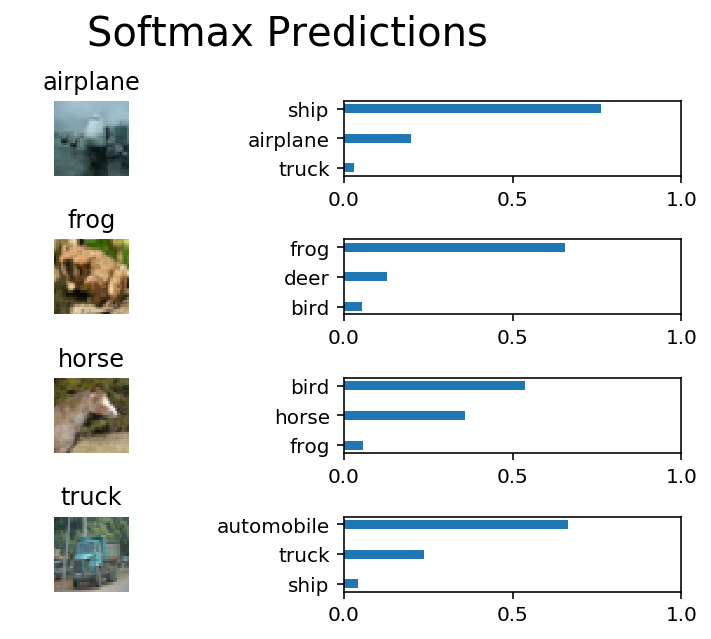

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## RESULTS
### Why 50-80% Accuracy?
50% isn't bad for a simple CNN.  Pure guessing would get 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). 

##### I will keep training the network to get closer to 90%!!